In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

# Hands-on Activity 23.5: Expected Improvement - With Observation Noise

## Objectives

+ Develop intuition about the expected improvement in the presence of observation noise

## Optimizing Noisy Functions

The optimization of noisy functions is relevant when you are dealing with experimentally measured objectives.
In such a scenario, you do not observe $f(\mathbf{x})$, but a noisy version of it.
Here is a prototypical scenario of an experimentally measured objective.
Let $\xi$ be all the variables that affect the objective and assume that they are distributed in a way, not necessarily known to you:
$$
\xi \sim p(\xi).
$$
The you setup your experiment using a design $\mathbf{x}$ and you measure:
$$
y = g(\mathbf{x}, \xi).
$$
Let's assume now, that you would like to maximize the expectation of this function, i.e., you want to maximize
$$
f(\mathbf{x}) = \mathbb{E}_\xi[g(\mathbf{x},\xi)].
$$
The expectation here is over the experimental noise.

A naïve way of solving this problem is to approximate the expectation using sample averaging.
That is, at each $\mathbf{x}$ you do many experiments instead of just one.
If your experiments are not very expensive, you may just do that.
Then any of the algorithms above would work in your problem.

So, what do you do when you cannot get rid of the noise?
Well, this is an open problem.
But here is a quick and dirty solution which may work in many cases.
First, use GPR to approximate $f(\mathbf{x})$ using noisy measurements:
$$
y_i = g(\mathbf{x},\xi_i),
$$
for $i=1,\dots,n$. 
Note that here you do not necessarily have to observe the $\xi$'s.
You can assume that they are hidden. If you do observe them, you can exploit this fact.
But, for now, let's assume that you don't observe them.
If you don't observe them you need to somehow model their effect.
The easier thing to do is to assume that their effect is additive, zero mean, and Gaussian.
That is, we just assume that:
$$
y_i = f(\mathbf{x}_i) + \epsilon_i,
$$
where $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$, where $\sigma^2$ is to be determined.
Of course, this is, in general, not the right assumption for the noise.
It is, however, the easiest thing to do.
When we do this, we can just use GPR to find our posterior state of knowledge about $f(\cdot)$ and any hyperparameters).
We will be just using a MAP estimate for the hyperparameters.

The posterior GP conditioned on the observed data is given by the usual formulas:
$$
f(\cdot)|\mathcal{D}_n \sim \operatorname{GP}(m_n(\cdot), k_n(\cdot,\cdot)).
$$
Since we will be doing sequential experiment design, we are also going to need the point-predictive distribution for the measurement $y$ at a hypothetical $\mathbf{x}$.
It is:
$$
p(y|\mathbf{x},\mathcal{D}_n) = \mathcal{N}(y|m_n(\mathbf{x}), \sigma_n^2(\mathbf{x}) + \sigma^2),
$$
where $\sigma_n^2(\mathbf{x}) = k_n(\mathbf{x},\mathbf{x})$, i.e., the posterior variance for $f(\mathbf{x})$.
We now have all the ingredients to modify the information acquisition functions we had above for the noisy cases.

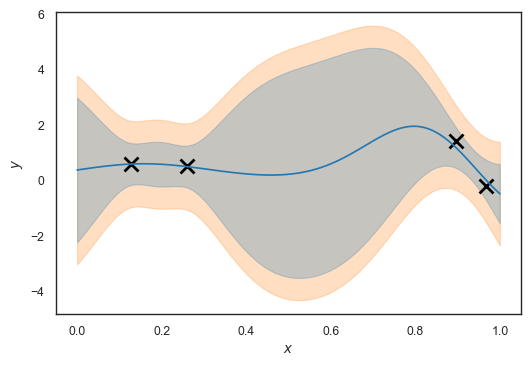

In [5]:
# As a working example let's generate data with noise
np.random.seed(123456) # For reproducibility
# The noise
sigma_noise = 0.4
# Here is the underlying function without any noise
def f(x):
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

# Here is a noisy function
def g(x):
    return f(x) + sigma_noise * np.random.randn(x.shape[0])

n_init = 4
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = g(X)

# The kernel we use
import GPy
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
# Assuming that we know the measurement noise (optimize otherwise, but you will need some data)
gpr.likelihood.variance.constrain_fixed(sigma_noise ** 2)
# You can evaluate the predictive distribution anywhere:
x = np.linspace(0, 1, 100)
mn, v = gpr.predict(x[:, None])
sigman2 = v - sigma_noise ** 2
# And you can visualize the results as follows
# Standard deviation
sigman = np.sqrt(sigman2)
# Lower quantile
l = mn - 1.96 * sigman
u = mn + 1.96 * sigman
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, mn)
ax.fill_between(x, l.flatten() - 2.0 * sigma_noise, u.flatten() + 2.0 * sigma_noise, color=sns.color_palette()[1], alpha=0.25);
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25);

## Maximum upper interval with noise

The maximum upper interval remains the same:
$$
a_n(\mathbf{x}) = \mu_n(\mathbf{x}) + \psi \sigma_n(\mathbf{x}),
$$
for some $\psi \ge 0$.
Just make sure you don't add the $\sigma^2$ term in the variance.
Of course, we need to modify the way we grab the variance from ``GPy`` for this.
Here it is:

In [9]:
def mui(m, sigma, ymax, psi=1.96):
    return m + psi * sigma

def plot_mui_w_noise(psi=0.):
    fig, ax = plt.subplots(dpi=100)
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, mn)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = mui(mn, sigman, Y.max(), psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('Maximum Upper Interval', color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)

from ipywidgets import interactive

interactive(plot_mui_w_noise, psi=(0., 4., 0.001))

interactive(children=(FloatSlider(value=0.0, description='psi', max=4.0, step=0.001), Output()), _dom_classes=…

## Probability of improvement with noise

We need to make some modifications to the probability of improvement.
First, we cannot just use the $y_n^*$ as the maximum of the $y_i$'s, because they are noisy.
Instead, we are looking at the predictive mean of the GP, $m_n(\mathbf{x}_i)$, at the corresponding inputs, $\mathbf{x}_i$, and we find their maximum.
So, define:
$$
m_n^* = \max_{1\le i\le n}m_n(\mathbf{x}_i).
$$
Essentially, instead of finding the maximum of the noisy observations, we are smoothing with the predictive mean of the GP and find the maximum of the smoothed versions.
The rest is similar.
The acquisition function is defined by:
$$
a_n(\mathbf{x}) = \mathbb{P}[f(\mathbf{x}) > m_n^* + \psi | \mathbf{x}, \mathcal{D}_n].
$$
We read "$a_n(\mathbf{x})$" is the probability that we observe at $x$ a $y$ that is greater than the currently observed maximum $y_n^*$ by at least $\psi>0$.
The good thing is that it is possible to get an analytical answer because our point predictive distribution is Gaussian.
In particular, we get:
$$
\begin{align}
a_n(\mathbf{x}) &=& \mathbb{P}[f(\mathbf{x}) > m_n^* + \psi | \mathbf{x}, \mathcal{D}_n]\\
&=& \mathbb{P}\left[\frac{f(\mathbf{x}) - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} > \frac{m_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& \dots\\
&=& \Phi\left(\frac{\mu_n(\mathbf{x}) - m_n^* - \psi}{\sigma_n(\mathbf{x})} \right).
\end{align}
$$


In [12]:
def poi(m, sigma, ymax, psi=0.):
    """
    Return the probability of improvement.
    
    Arguments:
    m        -      the predictive mean at the test points.
    sigma        -  the predictive standard deviation at the test points.
    ymax     -      the maximum observed value (so far).
    psi      -      a parameter that controls exploration.
    """
    return st.norm.cdf((m - ymax - psi) / sigma)

# We just need to get the smoothed versions of the observed y's
y_smoothed = gpr.predict(X[:, None])[0]
# and then their maximum
mn_star = y_smoothed.max()

def plot_poi_w_noise(psi=0.):
    fig, ax = plt.subplots(dpi=100)
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, mn)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = poi(mn, sigman, mn_star, psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('Probability of Improvement', color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), 
             color=sns.color_palette()[1], linewidth=1)
    ax2.set_ylim(0, 1)

interactive(plot_poi_w_noise, psi=(0., 4., 0.001))

interactive(children=(FloatSlider(value=0.0, description='psi', max=4.0, step=0.001), Output()), _dom_classes=…

## Expected improvment with noise

The arguments here are as in the previous section about the probability of improvement.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best observed point $m_n^*$.
It is:
$$
I_n(\mathbf{x}, f(\mathbf{x})) =
\begin{cases}
0,&\;\text{if}\;f(\mathbf{x}) \le m_n^*,\\
f(\mathbf{x}) - m_n^*,&\;\text{otherwise},
\end{cases}
$$
and this conditional of $y$, i.e., $f(\mathbf{x})$ is a random variable conditioned on $y$.
Taking the expectation over $y$ would give you:
$$
\operatorname{EI}_n(\mathbf{x}) = \frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\Phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right)
+ \phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right).
$$

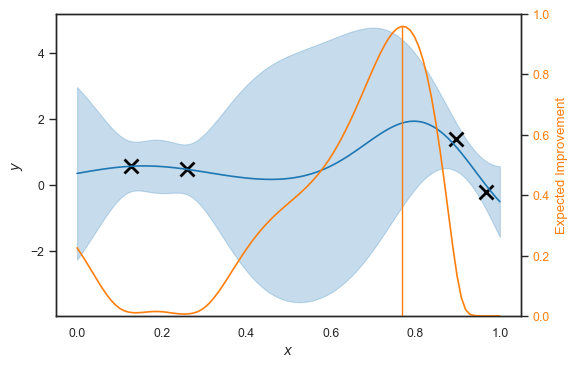

In [15]:
def ei(m, sigma, ymax, psi=0.):
    u = (m - ymax) / sigma
    ei = sigma * (u * st.norm.cdf(u) + st.norm.pdf(u))
    ei[sigma <= 0.] = 0.
    return ei

af_values = ei(mn, sigman, mn_star)
idx = np.argmax(af_values)
af_max = af_values[idx]
next_x = x[idx]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, mn)
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
ax2 = ax.twinx()
ax2.plot(x, af_values, color=sns.color_palette()[1])
plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
ax2.set_ylabel('Expected Improvement', color=sns.color_palette()[1])
ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
ax2.set_ylim(0, 1);

Let's modify now our sequential information acquisition algorithm so that it works with noise:

In [18]:
def maximize_w_noise(g, gpr, X_design, alpha=ei, psi=0., max_it=6):
    """
    Optimize f using a limited number of evaluations.
    
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param alpha:    The acquisition function.
    :param psi:      The parameter value for the acquisition function (not used for EI).
    :param max_it:   The maximum number of iterations.
    """
    af_all = []
    for count in range(max_it):
        mn, v = gpr.predict(X_design)
        sigman2 = v - gpr.likelihood.variance
        sigman = np.sqrt(sigman2)
        l = mn - 1.96 * sigman
        u = mn + 1.96 * sigman
        y_smoothed = gpr.predict(gpr.X)[0]
        mn_star = y_smoothed.max()
        af_values = alpha(mn, sigman, mn_star, psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [g(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots(dpi=100)
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, mn)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
    return af_all

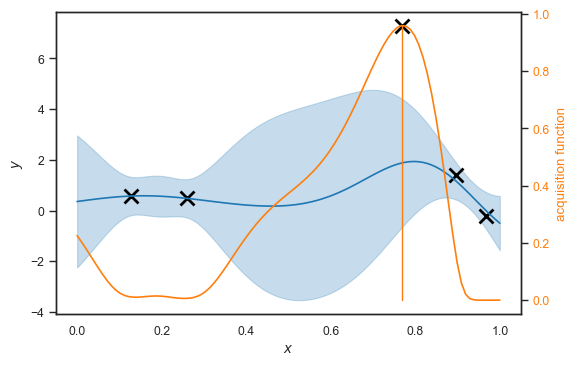

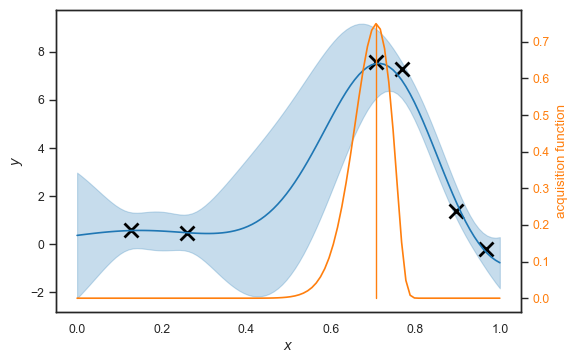

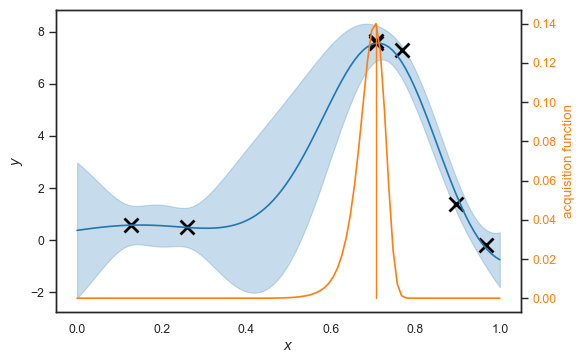

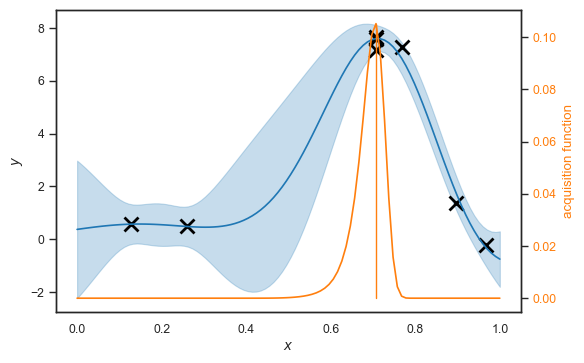

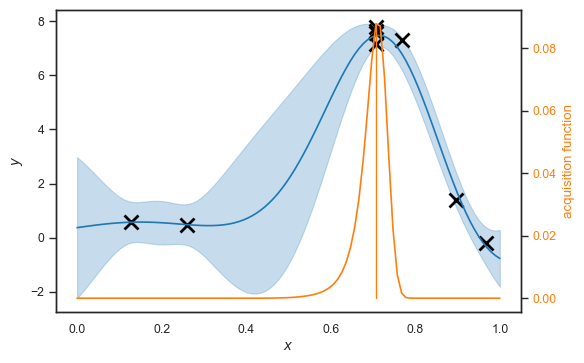

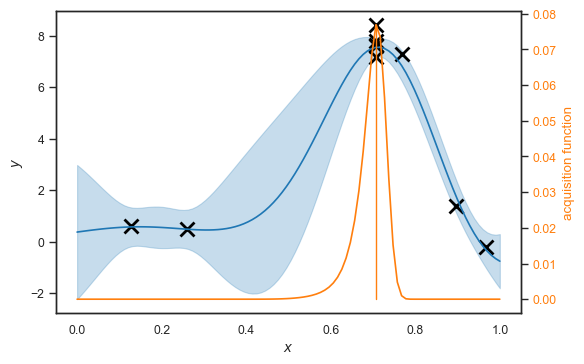

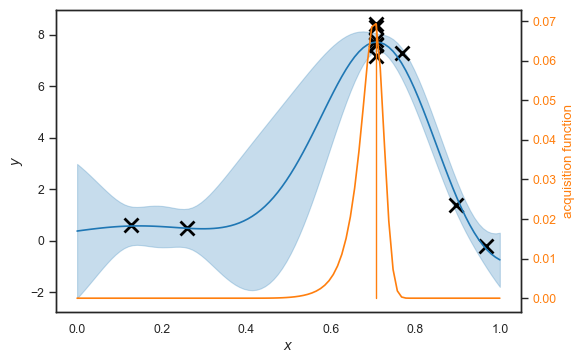

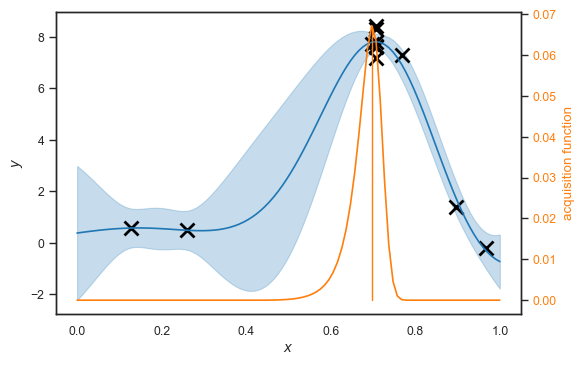

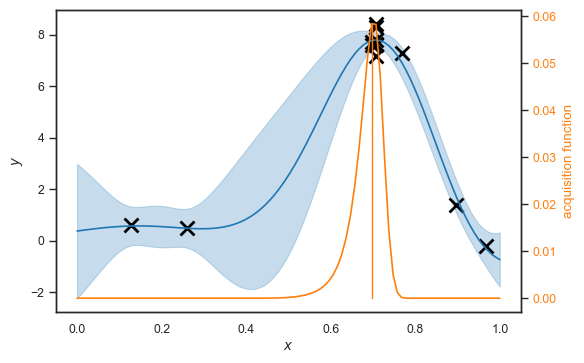

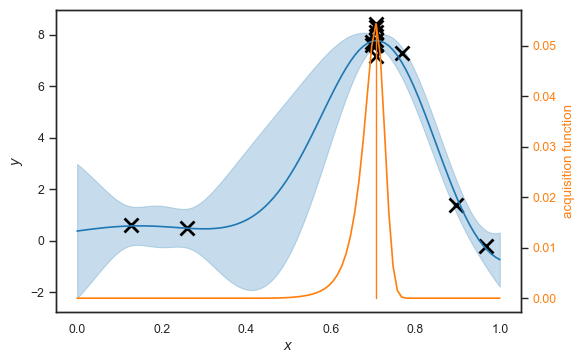

In [19]:
# As a working example let's generate data with noise
np.random.seed(123456) # For reproducibility
# The noise
sigma_noise = 0.4
# Here is a noisy function
def g(x):
    return f(x) + sigma_noise * np.random.randn(x.shape[0])

n_init = 4
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = g(X)

# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(sigma_noise ** 2)
# Run the algorithm
af_all = maximize_w_noise(g, gpr, x[:, None], alpha=ei, psi=0., max_it=10)

## Questions

+ Rerun the algorithm above starting with 3 observations. Does the algorithm find the same local maximum?
If not, why?
+ Experiment with smaller noise. 
+ Experiment with larger noise.